In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy import misc, ndimage
import glob
import matplotlib.image as mpimg
import cv2

#from transform_image_data import centre_crop

%matplotlib inline

In [2]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
print(tf.__version__)

Default GPU Device:/device:GPU:0
2.1.0


In [3]:
#import Data

train_folder = "C:/Users/Hameez/.conda/envs/gemstone_dataset/Data/Cropped/Train/"
test_folder = "C:/Users/Hameez/.conda/envs/gemstone_dataset/Data/Cropped/Test/"


# img = image.load_img(train_folder+"/Alexandrite/alexandrite_2.jpg")
# # plt.imshow(img)
# # plt.show()
# print(cv2.imread("Data/Train/Alexandrite/alexandrite_24.jpg").shape)

#------------Image augmentation for train images----------------------------------#
train = ImageDataGenerator(rescale=1./255, shear_range=0.5,
                           rotation_range=90, channel_shift_range=2.5, 
                           zoom_range=0.3,
                           horizontal_flip=True)

#---------------------------------------------------------------------------#

test = ImageDataGenerator(rescale=1./255)

im_height = im_width = 224

batch_sz = 32

train_data = train.flow_from_directory(train_folder,
                                       target_size=(im_height,im_width),
                                       class_mode='categorical', batch_size=batch_sz)
test_data = test.flow_from_directory(test_folder,
                                       target_size=(im_height,im_width),
                                       class_mode='categorical')





Found 2857 images belonging to 87 classes.
Found 363 images belonging to 87 classes.


### CNN Model 

In [4]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False)
#base_model.summary()

C:\Users\Hameez\.conda\envs\gpu_tf\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [5]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.BatchNormalization()(x)
predictions =  tf.keras.layers.Dense(87, activation='softmax')(x)

for layers in base_model.layers:
    layers.trainable = False # freeze layers that we dont want to train
    

final_model = tf.keras.models.Model(inputs=base_model.inputs, outputs=predictions)
sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
#final_model.summary()

In [6]:
final_model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])

history = final_model.fit_generator(train_data, epochs=10, validation_data=test_data, verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 90 steps, validate for 12 steps
Epoch 1/10
90/90 [==============================] - 54s 602ms/step - loss: 4.5044 - accuracy: 0.0641 - val_loss: 4.1940 - val_accuracy: 0.0744
Epoch 2/10
90/90 [==============================] - 49s 542ms/step - loss: 3.2030 - accuracy: 0.2398 - val_loss: 3.9156 - val_accuracy: 0.1047
Epoch 3/10
90/90 [==============================] - 51s 562ms/step - loss: 2.5751 - accuracy: 0.3651 - val_loss: 3.9084 - val_accuracy: 0.1240
Epoch 4/10
90/90 [==============================] - 66s 732ms/step - loss: 2.2298 - accuracy: 0.4228 - val_loss: 4.1205 - val_accuracy: 0.1240
Epoch 5/10
90/90 [==============================] - 89s 985ms/step - loss: 1.9526 - accuracy: 0.4865 - val_loss: 4.2784 - val_accuracy: 0.1433
Epoch 6/10
90/90 [==============================] - 103s 1s/step - loss: 1.8354 - accuracy: 0.5187 - val_loss: 4.4872

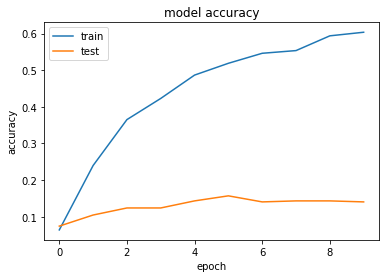

In [9]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

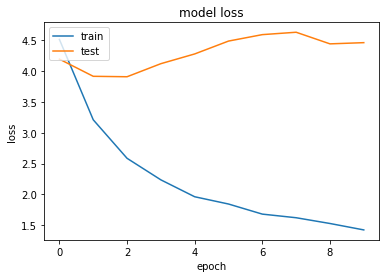

In [10]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:

model_path ='Saved Models Transfer/gs_MobileNetV2_v1.1.h5'
final_model.save(model_path)

model = tf.keras.models.load_model(model_path)

In [ ]:
unsean_stone_path = "C:/Users/Hameez/.conda/envs/gemstone_dataset/Data/Unseen/blue_sapph.jpg"
img = image.load_img(unsean_stone_path, target_size=(im_height, im_width))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print(os.path.basename(unsean_stone_path))
img

In [ ]:
preds = model.predict(x)
classess = train_data.class_indices
for name in classess:
    if classess[name] == int(preds.argmax(axis=-1)):
        print("Predicts that its a: "+name)
    else:
        "Couldn't find stone name!"